# Time Series Analysis

## Libraries and Datasets

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
from statsmodels.tsa.api import ExponentialSmoothing ,SimpleExpSmoothing ,Holt
import statsmodels.api as sm
# evelute for accuracy
from sklearn.metrics import mean_squared_error
from math import sqrt


%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

In [240]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

train_original =  train.copy()
test_original =  test.copy()

## EDA

In [241]:
train.columns

Index(['ID', 'Datetime', 'Count'], dtype='object')

In [242]:
train.shape

(18288, 3)

In [243]:
train.dtypes

ID           int64
Datetime    object
Count        int64
dtype: object

In [244]:
test.columns

Index(['ID', 'Datetime'], dtype='object')

In [245]:
test.shape

(5112, 2)

In [246]:
test.dtypes

ID           int64
Datetime    object
dtype: object

## Feature Engineering

In [247]:
train['Datetime'] = pd.to_datetime(train.Datetime,format = '%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format = '%d-%m-%Y %H:%M')

In [248]:
test_original['Datetime'] = pd.to_datetime(train_original.Datetime , format= '%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(test_original.Datetime , format= '%d-%m-%Y %H:%M')

In [249]:
for i in(train,test_original,test,train_original):
    i['year'] = i.Datetime.dt.year
    i['month'] = i.Datetime.dt.month
    i['day'] = i.Datetime.dt.day
    i['Hour'] = i.Datetime.dt.hour

In [250]:
train['dayofweek'] = train['Datetime'].dt.dayofweek
temp = train['Datetime']

In [251]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0

temp2 = train.Datetime.apply(applyer)
train['weekend'] = temp2

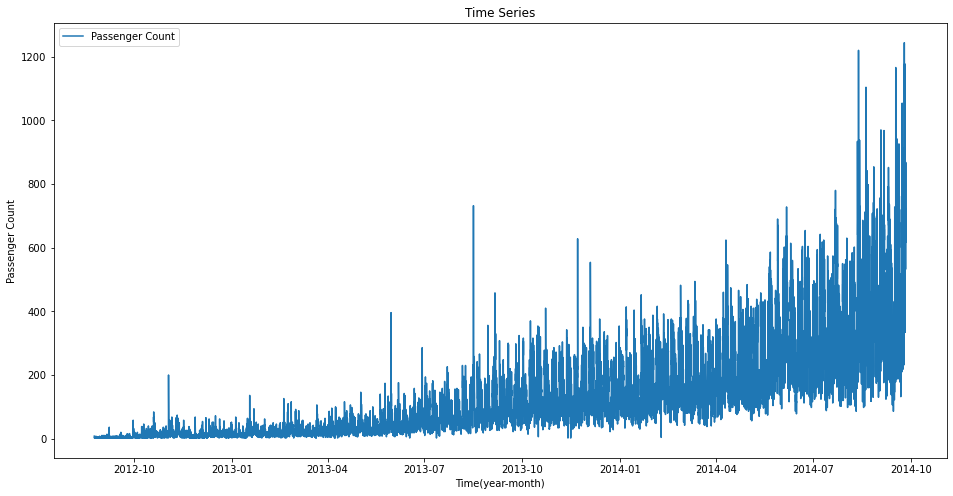

In [252]:
train.index = train.Datetime
df =  train.drop(columns='ID')
ts = df['Count']
plt.figure(figsize = (16,8))
plt.plot(ts,label = 'Passenger Count')
plt.title('Time Series')
plt.xlabel('Time(year-month)')
plt.ylabel('Passenger Count')
plt.legend(loc = 'best')

### exploratory analysis

<AxesSubplot:xlabel='year'>

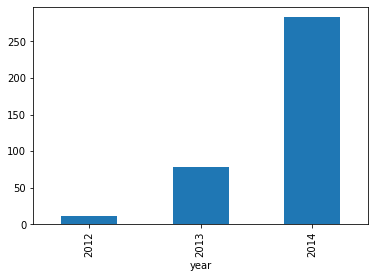

In [253]:
train.groupby('year')['Count'].mean().plot.bar()

There was a increase of trafic from 2012- 2014

<AxesSubplot:xlabel='month'>

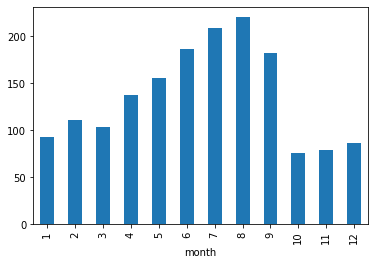

In [254]:
train.groupby('month')['Count'].mean().plot.bar()

Many people travel during the months of June to August

<AxesSubplot:title={'center':'Passenger Count(Monthwise)'}, xlabel='year,month'>

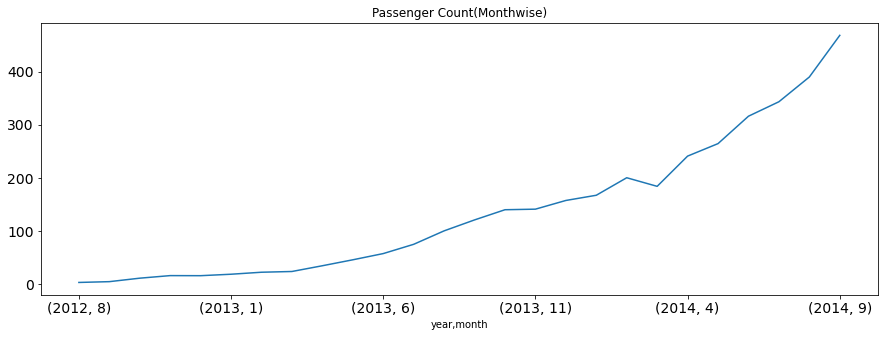

In [255]:
temp = train.groupby(['year','month'])['Count'].mean()
temp.plot(figsize=(15,5),title = 'Passenger Count(Monthwise)',fontsize=14)


there is a gradual increase of in traffic from the year 2012 -2014 

<AxesSubplot:xlabel='day'>

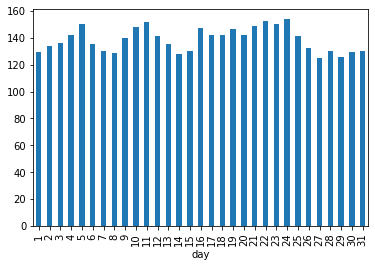

In [256]:
train.groupby('day')['Count'].mean().plot.bar()

<AxesSubplot:xlabel='Hour'>

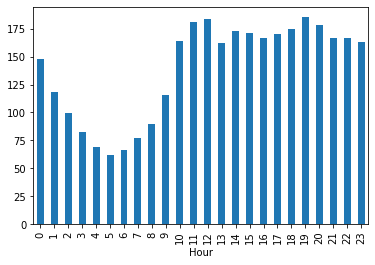

In [257]:
train.groupby('Hour')['Count'].mean().plot.bar()

- 5 am is the least travelled time of the day
- while 11am - 11pm is the most travelled.

<AxesSubplot:xlabel='weekend'>

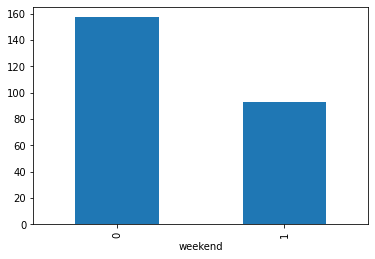

In [258]:
train.groupby('weekend')['Count'].mean().plot.bar()

<AxesSubplot:xlabel='dayofweek'>

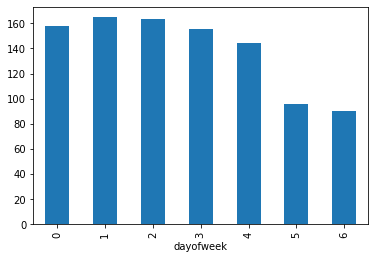

In [259]:
train.groupby('dayofweek')['Count'].mean().plot.bar()

The first 4 days of the week are most travelled

In [260]:
train = train.drop(columns='ID')

In [261]:
train.Timestmps = pd.to_datetime(train.Datetime,format = '%d-%m-%Y %H:%M')
train.index = train.Timestmps
hourly = train.resample('H').mean()
daily = train.resample('D').mean()
weekly = train.resample('W').mean()
monthly = train.resample('M').mean()

Hourly plot

<AxesSubplot:title={'center':' Hourly'}, xlabel='Datetime'>

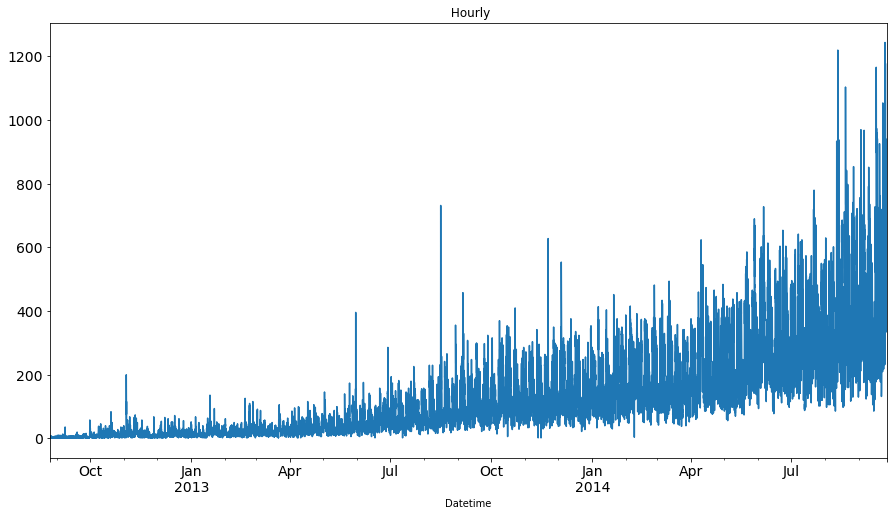

In [262]:
hourly.Count.plot(figsize=(15,8),title =' Hourly' ,fontsize= 14 )

Daily plot

<AxesSubplot:title={'center':' Daily'}, xlabel='Datetime'>

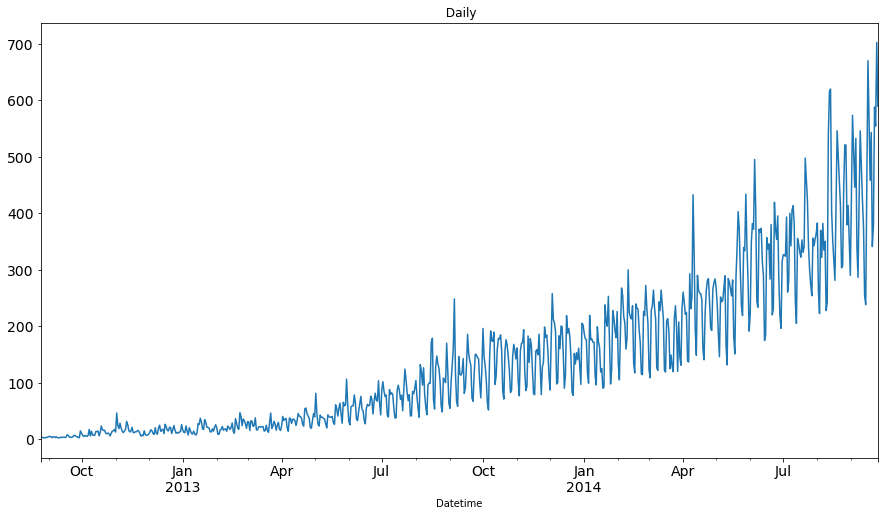

In [263]:
daily.Count.plot(figsize=(15,8),title =' Daily' ,fontsize= 14)

Weekly plot

<AxesSubplot:title={'center':' Weekly '}, xlabel='Datetime'>

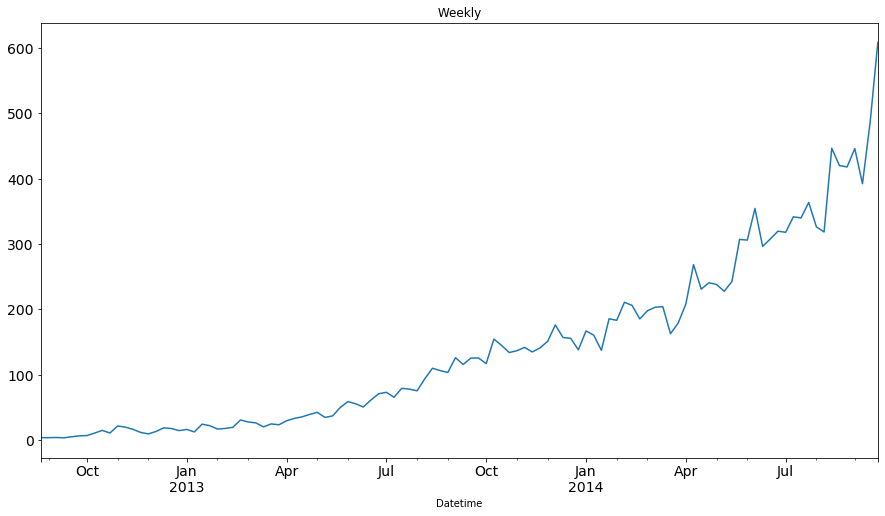

In [264]:
weekly.Count.plot(figsize=(15,8),title =' Weekly ' ,fontsize= 14 )

Monthly plot

<AxesSubplot:title={'center':' Monthly '}, xlabel='Datetime'>

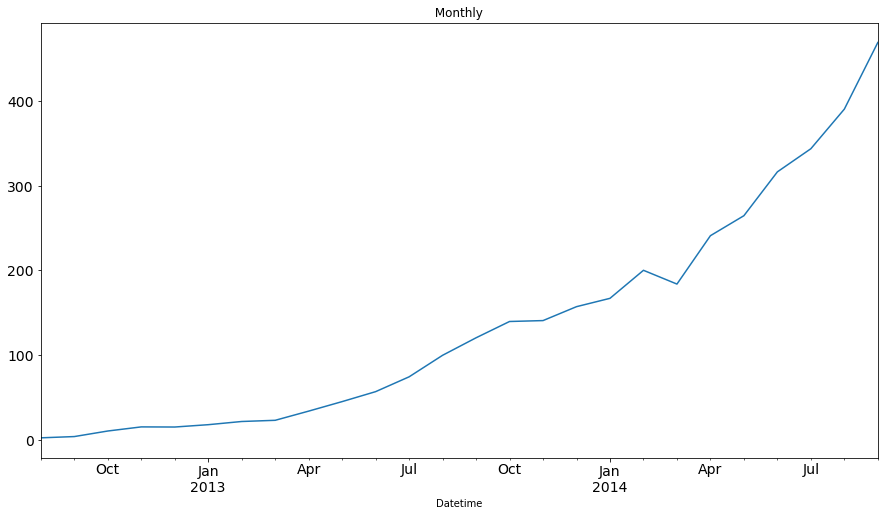

In [265]:
monthly.Count.plot(figsize=(15,8),title =' Monthly ' ,fontsize= 14)

In [266]:
test.Timestmps = pd.to_datetime(test.Datetime,format = '%d-%m-%Y %H:%M')
test.index = test.Timestmps


In [267]:
test

,ID,Datetime,year,month,day,Hour
Datetime,,,,,,
2014-09-26 00:00:00,18288,2014-09-26 00:00:00,2014,9,26,0
2014-09-26 01:00:00,18289,2014-09-26 01:00:00,2014,9,26,1
2014-09-26 02:00:00,18290,2014-09-26 02:00:00,2014,9,26,2
2014-09-26 03:00:00,18291,2014-09-26 03:00:00,2014,9,26,3
2014-09-26 04:00:00,18292,2014-09-26 04:00:00,2014,9,26,4
...,...,...,...,...,...,...
2015-04-26 19:00:00,23395,2015-04-26 19:00:00,2015,4,26,19
2015-04-26 20:00:00,23396,2015-04-26 20:00:00,2015,4,26,20
2015-04-26 21:00:00,23397,2015-04-26 21:00:00,2015,4,26,21


In [268]:
train.Timestmps = pd.to_datetime(train.Datetime,format = '%d-%m-%Y %H:%M')
train.index = train.Timestmps
train = train.resample('D').mean()


## Modelling and evaluation

splitting data

In [269]:
Train = train.loc['2012-08-25':'2014-06-24']
valid = train.loc['2014-06-25':'2014-09-25']

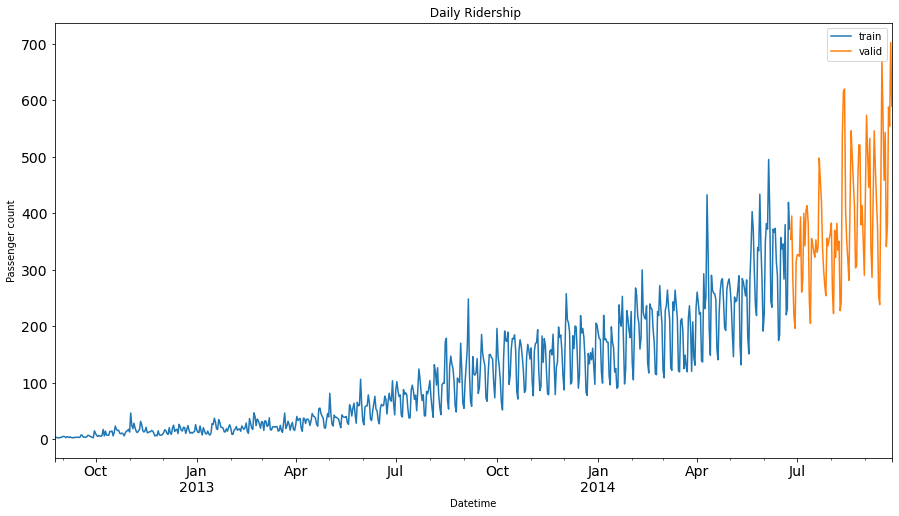

In [270]:
Train.Count.plot(figsize =(15,8), title = 'Daily Ridership' , fontsize = 14 , label = 'train')
valid.Count.plot(figsize = (15, 8),title = ' Daily Ridership' , fontsize = 14 , label = 'valid')
plt.xlabel('Datetime')
plt.ylabel('Passenger count')
plt.legend(loc = 'best')
plt.show()

Naive Approach

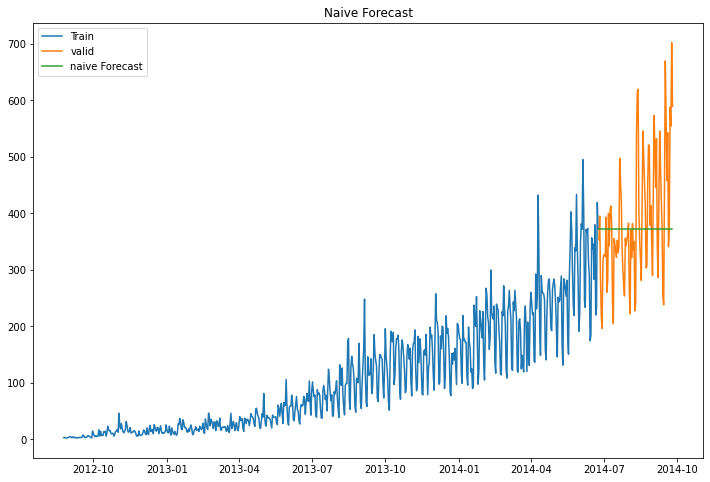

In [271]:
dd = np.asarray(Train.Count)
y_hat = valid.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize = (12,8))
plt.plot(Train.Count , label = 'Train')
plt.plot(valid.Count , label = 'valid')
plt.plot(y_hat.naive , label = 'naive Forecast')
plt.legend( loc = 'best')
plt.title('Naive Forecast')
plt.show()

In [272]:
rms = sqrt(mean_squared_error(valid.Count , y_hat.naive))
print(rms)

111.79050467496724


moving average(ma)

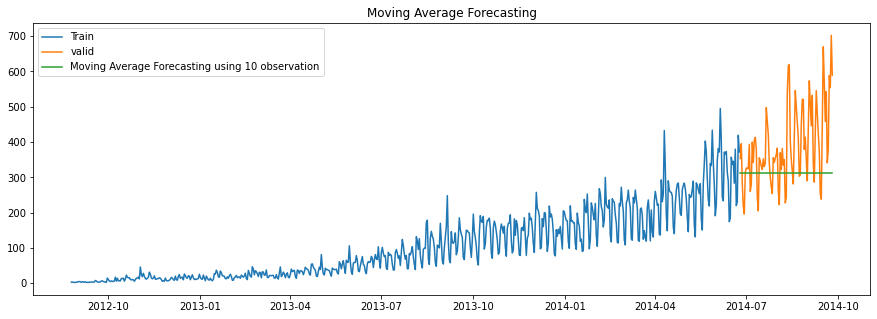

In [273]:
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train.Count.rolling(10).mean().iloc[-1]
plt.figure(figsize = (15,5))
plt.plot(Train.Count , label = 'Train')
plt.plot(valid.Count , label = 'valid')
plt.plot(y_hat_avg.moving_avg_forecast , label = 'Moving Average Forecasting using 10 observation')
plt.legend(loc = 'best')
plt.title('Moving Average Forecasting')
plt.show()

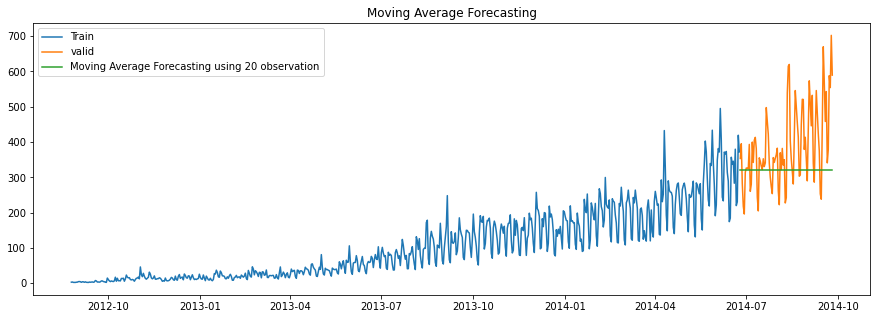

In [274]:
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train.Count.rolling(20).mean().iloc[-1]
plt.figure(figsize = (15,5))
plt.plot(Train.Count , label = 'Train')
plt.plot(valid.Count , label = 'valid')
plt.plot(y_hat_avg.moving_avg_forecast , label = 'Moving Average Forecasting using 20 observation')
plt.legend(loc = 'best')
plt.title('Moving Average Forecasting')
plt.show()

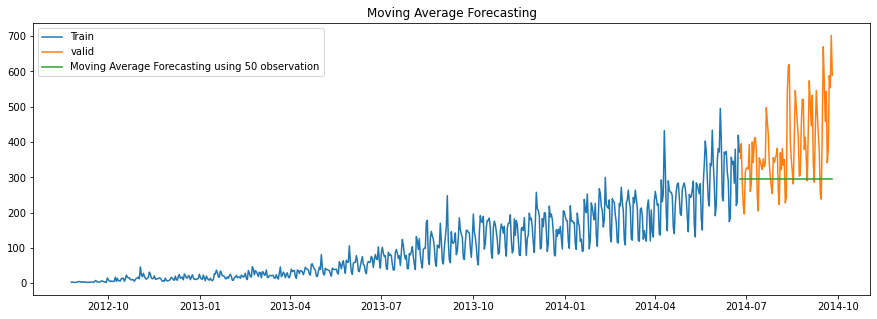

In [275]:
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train.Count.rolling(50).mean().iloc[-1]
plt.figure(figsize = (15,5))
plt.plot(Train.Count , label = 'Train')
plt.plot(valid.Count , label = 'valid')
plt.plot(y_hat_avg.moving_avg_forecast , label = 'Moving Average Forecasting using 50 observation')
plt.legend(loc = 'best')
plt.title('Moving Average Forecasting')
plt.show()

In [276]:
rms = sqrt(mean_squared_error(valid.Count,y_hat_avg.moving_avg_forecast))
print(rms)

144.19175679986793


simple exponential smoothing

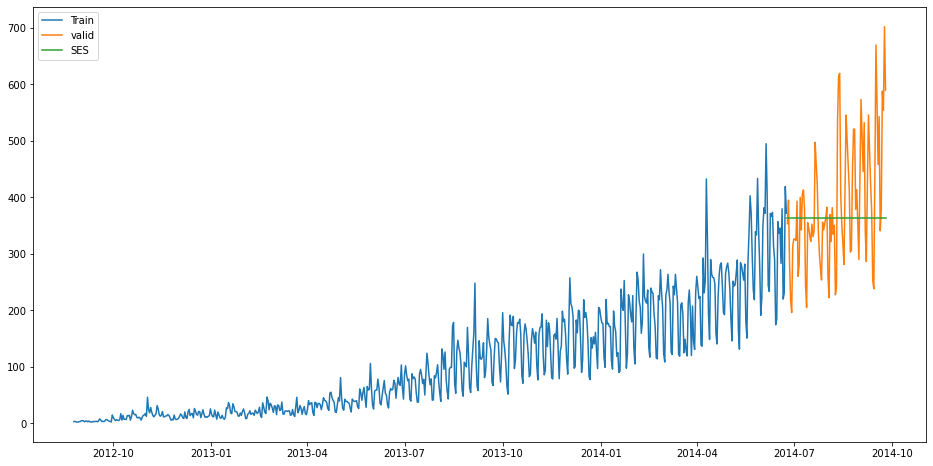

In [277]:
y_hat_avg = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(Train.Count)).fit(smoothing_level=0.6 ,optimized = False)
y_hat_avg['SES'] = fit2.forecast(len(valid))
plt.figure(figsize= (16 ,8))
plt.plot(Train.Count , label = 'Train')
plt.plot(valid.Count ,label = 'valid')
plt.plot(y_hat_avg.SES ,label = 'SES')
plt.legend(loc = 'best')
plt.show()

In [278]:
rms = sqrt(mean_squared_error(valid.Count , y_hat_avg.SES))
print(rms)

113.43708111884514


Holt's Linear Trend Model

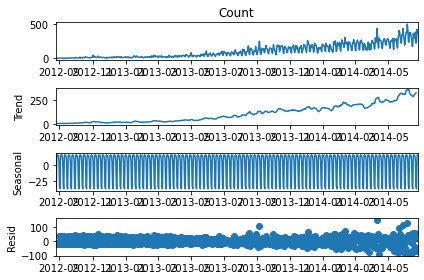

<Figure size 1080x576 with 0 Axes>

In [279]:
sm.tsa.seasonal_decompose(Train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.figure(figsize = (15,8))
plt.show()

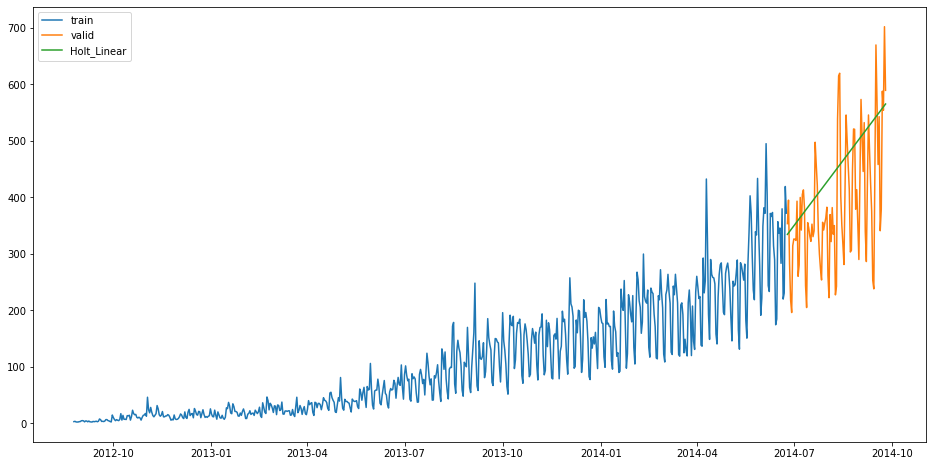

In [280]:
y_hat_avg = valid.copy()
fit1 = Holt(np.asarray(Train.Count)).fit(smoothing_level = 0.3 , smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid))

plt.figure(figsize = (16,8 ))
plt.plot(Train.Count , label = 'train')
plt.plot(valid.Count , label = 'valid')
plt.plot(y_hat_avg.Holt_linear , label = 'Holt_Linear')
plt.legend(loc  = 'best')
plt.show()

In [281]:
rms = sqrt(mean_squared_error(valid.Count , y_hat_avg.Holt_linear))
rms

112.94278345314041

holt's linear trend on daily time series

In [282]:
submission = pd.read_csv('sample_submission.csv')

In [283]:
predict = fit1.forecast(len(test))

In [284]:
test['prediction'] = predict

In [285]:
train_original['ratio'] = train_original.Count/train_original.Count.sum()

temp = train_original.groupby('Hour')['ratio'].sum()
pd.DataFrame(temp).to_csv('GROUPby.csv' )

In [286]:
temp2 = pd.read_csv('GROUPby.csv')

In [287]:
temp2

,Hour,ratio
0,0.0,0.001521
1,1.0,0.001269
2,2.0,0.001114
3,3.0,0.000906
4,4.0,0.000765
5,5.0,0.000690
6,6.0,0.000704
7,7.0,0.000751
8,8.0,0.000921
9,9.0,0.001094


In [288]:
merge = pd.merge(test ,test_original , on =('day' , 'month' , 'year') ,how = 'left')

In [291]:
merge

,ID_x,Datetime_x,year,month,day,Hour_x,prediction,ID_y,Datetime_y,Hour_y,Hour
0,18288,2014-09-26 00:00:00,2014,9,26,0,334.650767,NaN,NaT,NaN,0
1,18289,2014-09-26 01:00:00,2014,9,26,1,337.159011,NaN,NaT,NaN,1
2,18290,2014-09-26 02:00:00,2014,9,26,2,339.667256,NaN,NaT,NaN,2
3,18291,2014-09-26 03:00:00,2014,9,26,3,342.175500,NaN,NaT,NaN,3
4,18292,2014-09-26 04:00:00,2014,9,26,4,344.683745,NaN,NaT,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...
5107,23395,2015-04-26 19:00:00,2015,4,26,19,13144.254990,NaN,NaT,NaN,19
5108,23396,2015-04-26 20:00:00,2015,4,26,20,13146.763235,NaN,NaT,NaN,20
5109,23397,2015-04-26 21:00:00,2015,4,26,21,13149.271479,NaN,NaT,NaN,21
5110,23398,2015-04-26 22:00:00,2015,4,26,22,13151.779723,NaN,NaT,NaN,22


In [292]:
merge['Hour'] = merge['Hour_x']
merge = merge.drop(columns=  ['year','month', 'Datetime_x','Datetime_y' , 'Hour_x', 'Hour_y','ID_y'])

In [293]:
merge

,ID_x,day,prediction,Hour
0,18288,26,334.650767,0
1,18289,26,337.159011,1
2,18290,26,339.667256,2
3,18291,26,342.175500,3
4,18292,26,344.683745,4
...,...,...,...,...
5107,23395,26,13144.254990,19
5108,23396,26,13146.763235,20
5109,23397,26,13149.271479,21
5110,23398,26,13151.779723,22


In [294]:
prediction = pd.merge(merge , temp2 , on = 'Hour' ,how = 'left')

In [295]:
prediction

,ID_x,day,prediction,Hour,ratio
0,18288,26,334.650767,0,0.001521
1,18289,26,337.159011,1,0.001269
2,18290,26,339.667256,2,0.001114
3,18291,26,342.175500,3,0.000906
4,18292,26,344.683745,4,0.000765
...,...,...,...,...,...
5107,23395,26,13144.254990,19,0.001762
5108,23396,26,13146.763235,20,0.001665
5109,23397,26,13149.271479,21,0.001636
5110,23398,26,13151.779723,22,0.001792


In [297]:


prediction['Count'] = prediction['prediction'] * prediction['ratio']* 24
prediction['ID'] = prediction['ID_x']

submission = prediction.drop(columns= ['ID_x' , 'day' , 'prediction' , 'Hour' ,'ratio'])

In [298]:
prediction

,ID_x,day,prediction,Hour,ratio,Count,ID
0,18288,26,334.650767,0,0.001521,12.212092,18288
1,18289,26,337.159011,1,0.001269,10.265756,18289
2,18290,26,339.667256,2,0.001114,9.078231,18290
3,18291,26,342.175500,3,0.000906,7.439013,18291
4,18292,26,344.683745,4,0.000765,6.328171,18292
...,...,...,...,...,...,...,...
5107,23395,26,13144.254990,19,0.001762,555.880169,23395
5108,23396,26,13146.763235,20,0.001665,525.194688,23396
5109,23397,26,13149.271479,21,0.001636,516.353699,23397
5110,23398,26,13151.779723,22,0.001792,565.638118,23398


In [299]:
pd.DataFrame(submission ,columns=['ID','Count']).to_csv('Holt_linear.csv' , index = False)